In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
pd.set_option('display.max_columns', None)

# Importing modules

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# Loading the dataset

In [ ]:
mdf = pd.read_csv('/content/drive/MyDrive/ML Project/match_data.csv')
mdf.shape

(816, 12)

Matches data will be used when we need to predict the winner before the match (maybe for seeding), whereas deliveries data will be used when we need to predict real time live scores as the match is happening.

The goal is to make two models, one for Match Outcome Prediction and another for Live Score Prediction.

In [ ]:
mdf.head()

,dates,city,season,host_team,visiting_team,toss_winner,toss_decision,venue,result,winner,player_of_match,match_id
0,2008-04-18,Bangalore,2008,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,M Chinnaswamy Stadium,1,Kolkata Knight Riders,BB McCullum,1.0
1,2008-04-19,Chandigarh,2008,Kings XI Punjab,Chennai Super Kings,Chennai Super Kings,bat,"Punjab Cricket Association Stadium, Mohali",1,Chennai Super Kings,MEK Hussey,2.0
2,2008-04-19 00:00:00,Delhi,2008,Delhi Daredevils,Rajasthan Royals,Rajasthan Royals,bat,Feroz Shah Kotla,1,Delhi Daredevils,MF Maharoof,3.0
3,2008-04-20,Kolkata,2008,Kolkata Knight Riders,Deccan Chargers,Deccan Chargers,bat,Eden Gardens,1,Kolkata Knight Riders,DJ Hussey,4.0
4,2008-04-20,Mumbai,2008,Mumbai Indians,Royal Challengers Bangalore,Mumbai Indians,bat,Wankhede Stadium,1,Royal Challengers Bangalore,MV Boucher,5.0


In [ ]:
mdf.columns

Index(['dates', 'city', 'season', 'host_team', 'visiting_team', 'toss_winner',
       'toss_decision', 'venue', 'result', 'winner', 'player_of_match',
       'match_id'],
      dtype='object')

# Data analysis and Pre-processing

In [ ]:
mdf_clone = mdf.copy() # Just in case.

The dataset seems to balanced enough with respect to the number of instances in each target class.

In [ ]:
team1_win_count = len(mdf.loc[mdf['host_team'] == mdf['winner']])
team2_win_count = len(mdf.loc[mdf['visiting_team'] == mdf['winner']])
team1_win_count, team2_win_count

(445, 367)

Adding timeseries features to take into consideration the seasonal patterns as well.

In [ ]:
import re

def remove_timestamp(value):
    expression = r'\d{4}-\d{2}-\d{2}'
    match = re.match(expression, value)
    if match:
        return match.group(0)
    return value

mdf['dates'] = mdf['dates'].apply(remove_timestamp)

In [ ]:
mdf['dayofyear'] = pd.to_datetime(mdf['dates']).dt.dayofyear
mdf['dayofweek'] = pd.to_datetime(mdf['dates']).dt.dayofweek
mdf['season'] = pd.to_datetime(mdf['dates']).dt.year

We don't need this anymore, so we can drop this feature.

In [ ]:
mdf = mdf.drop(columns=['dates'])

Since this dataset has data on matches that happened throughout several years, it has different team names for some of the teams. So we map all of them to simply the city name. This makes it easier to also check if the teams are on home ground.

In [ ]:
team_city_map = {
    'Sunrisers Hyderabad': 'Hyderabad',
    'Deccan Chargers': 'Hyderabad',
    'Mumbai Indians': 'Mumbai',
    'Gujarat Lions': 'Gujarat',
    'Gujarat Titans': 'Gujarat',
    'Rising Pune Supergiants': 'Pune',
    'Rising Pune Supergiant': 'Pune',
    'Pune Warriors': 'Pune',
    'Royal Challengers Bangalore': 'Bangalore',
    'Royal Challengers Bengaluru': 'Bangalore',
    'Kolkata Knight Riders': 'Kolkata',
    'Delhi Daredevils': 'Delhi',
    'Delhi Capitals': 'Delhi',
    'Kings XI Punjab': 'Punjab',
    'Punjab Kings': 'Punjab',
    'Chennai Super Kings': 'Chennai',
    'Rajasthan Royals': 'Rajasthan',
    'Kochi Tuskers Kerala': 'Kochi',
    'Lucknow Super Giants': 'Lucknow'
}

def team_to_city(df, feature):
    df[feature] = df[feature].map(team_city_map)
    return df

def map_team_city(df):
    mdf = df.copy()
    for feature in ['host_team', 'visiting_team', 'toss_winner', 'winner']:
        if feature in mdf.columns:
            mdf = team_to_city(mdf, feature)
    return mdf

mdf = map_team_city(mdf)

We drop all rows with result value as 'no result' since they don't give us any useful infromation with regards to the result of the match.

In [ ]:
mdf['host_home'] = False
mdf['visiting_home'] = False

mdf.loc[mdf['host_team']== mdf['city'], 'host_home'] = True
mdf.loc[mdf['host_team']== mdf['city'], 'visiting_home'] = False
mdf.loc[mdf['visiting_team']== mdf['city'], 'visiting_home'] = True
mdf.loc[mdf['visiting_team']== mdf['city'], 'host_home'] = False


In [ ]:
mdf.head()

,city,season,host_team,visiting_team,toss_winner,toss_decision,venue,result,winner,player_of_match,match_id,dayofyear,dayofweek,host_home,visiting_home
0,Bangalore,2008,Bangalore,Kolkata,Bangalore,field,M Chinnaswamy Stadium,1,Kolkata,BB McCullum,1.0,109,4,True,False
1,Chandigarh,2008,Punjab,Chennai,Chennai,bat,"Punjab Cricket Association Stadium, Mohali",1,Chennai,MEK Hussey,2.0,110,5,False,False
2,Delhi,2008,Delhi,Rajasthan,Rajasthan,bat,Feroz Shah Kotla,1,Delhi,MF Maharoof,3.0,110,5,True,False
3,Kolkata,2008,Kolkata,Hyderabad,Hyderabad,bat,Eden Gardens,1,Kolkata,DJ Hussey,4.0,111,6,True,False
4,Mumbai,2008,Mumbai,Bangalore,Mumbai,bat,Wankhede Stadium,1,Bangalore,MV Boucher,5.0,111,6,True,False


In [ ]:
mdf['city'].value_counts()

city
Mumbai            101
Kolkata            77
Delhi              74
Bangalore          65
Hyderabad          64
Chennai            57
Chandigarh         56
Jaipur             47
Pune               38
Abu Dhabi          29
Bengaluru          15
Durban             15
Visakhapatnam      13
Centurion          12
Ahmedabad          12
Rajkot             10
Dharamsala          9
Indore              9
Johannesburg        8
Cuttack             7
Cape Town           7
Ranchi              7
Port Elizabeth      7
Raipur              6
Kochi               5
Kanpur              4
East London         3
Nagpur              3
Kimberley           3
Bloemfontein        2
Name: count, dtype: int64

In [ ]:
mdf.isna().sum()

city               51
season              0
host_team           0
visiting_team       0
toss_winner         0
toss_decision       0
venue               0
result              0
winner              4
player_of_match     4
match_id            0
dayofyear           0
dayofweek           0
host_home           0
visiting_home       0
dtype: int64

The method feature has too many null values to impute. We will drop this column as all it does is inform if D/L method was applied. And if it was indeed applied, we don't need that row.

Making new features team1_avg_score and team2_avg_score by iterating through the dataset and creating a database (here it's just a dictionary)

In [ ]:
mdf.head()

,city,season,host_team,visiting_team,toss_winner,toss_decision,venue,result,winner,player_of_match,match_id,dayofyear,dayofweek,host_home,visiting_home
0,Bangalore,2008,Bangalore,Kolkata,Bangalore,field,M Chinnaswamy Stadium,1,Kolkata,BB McCullum,1.0,109,4,True,False
1,Chandigarh,2008,Punjab,Chennai,Chennai,bat,"Punjab Cricket Association Stadium, Mohali",1,Chennai,MEK Hussey,2.0,110,5,False,False
2,Delhi,2008,Delhi,Rajasthan,Rajasthan,bat,Feroz Shah Kotla,1,Delhi,MF Maharoof,3.0,110,5,True,False
3,Kolkata,2008,Kolkata,Hyderabad,Hyderabad,bat,Eden Gardens,1,Kolkata,DJ Hussey,4.0,111,6,True,False
4,Mumbai,2008,Mumbai,Bangalore,Mumbai,bat,Wankhede Stadium,1,Bangalore,MV Boucher,5.0,111,6,True,False


In [ ]:
# Imputing NaN values using most_frequent strategy (manually)

mdf['city'] = mdf['city'].fillna('Mumbai')

In [ ]:
mdf = mdf.dropna()

In [ ]:
# One-Hot encoding toss_decision

mdf = pd.get_dummies(mdf, columns = ['toss_decision'], drop_first=True)

In [ ]:
mdf = mdf.drop(columns=['match_id', 'result'])

In [ ]:
mdf.head()

,city,season,host_team,visiting_team,toss_winner,venue,winner,player_of_match,dayofyear,dayofweek,host_home,visiting_home,toss_decision_field
0,Bangalore,2008,Bangalore,Kolkata,Bangalore,M Chinnaswamy Stadium,Kolkata,BB McCullum,109,4,True,False,True
1,Chandigarh,2008,Punjab,Chennai,Chennai,"Punjab Cricket Association Stadium, Mohali",Chennai,MEK Hussey,110,5,False,False,False
2,Delhi,2008,Delhi,Rajasthan,Rajasthan,Feroz Shah Kotla,Delhi,MF Maharoof,110,5,True,False,False
3,Kolkata,2008,Kolkata,Hyderabad,Hyderabad,Eden Gardens,Kolkata,DJ Hussey,111,6,True,False,False
4,Mumbai,2008,Mumbai,Bangalore,Mumbai,Wankhede Stadium,Bangalore,MV Boucher,111,6,True,False,False


In [ ]:
mdf = mdf.drop(columns=['player_of_match'])

In [ ]:
mdf['winner'].value_counts()

winner
Mumbai       120
Chennai      106
Kolkata       99
Hyderabad     95
Bangalore     91
Punjab        88
Delhi         86
Rajasthan     81
Pune          27
Gujarat       13
Kochi          6
Name: count, dtype: int64

In [ ]:
matches_won = dict(mdf['winner'].value_counts())

In [ ]:
matches_won

{'Mumbai': 120,
 'Chennai': 106,
 'Kolkata': 99,
 'Hyderabad': 95,
 'Bangalore': 91,
 'Punjab': 88,
 'Delhi': 86,
 'Rajasthan': 81,
 'Pune': 27,
 'Gujarat': 13,
 'Kochi': 6}

In [ ]:
team1_played = dict(mdf['host_team'].value_counts())
team2_played = dict(mdf['visiting_team'].value_counts())

matches_played = {}
for team, count in team1_played.items():
    if team not in matches_played.keys():
        matches_played[team] = 0
    matches_played[team] += count

for team, count in team2_played.items():
    if team not in matches_played.keys():
        matches_played[team] = 0
    matches_played[team] += count

In [ ]:
matches_played

{'Bangalore': 192,
 'Delhi': 192,
 'Hyderabad': 199,
 'Mumbai': 203,
 'Kolkata': 192,
 'Chennai': 178,
 'Punjab': 190,
 'Rajasthan': 159,
 'Pune': 75,
 'Gujarat': 30,
 'Kochi': 14}

Calculating and adding win ratio of each team in the dataset.

In [ ]:
# Calculating the win ratio of every team

win_ratio = {}
for team, count in matches_played.items():
    win_ratio[team] = matches_won[team] / count

win_ratio

{'Bangalore': 0.4739583333333333,
 'Delhi': 0.4479166666666667,
 'Hyderabad': 0.47738693467336685,
 'Mumbai': 0.5911330049261084,
 'Kolkata': 0.515625,
 'Chennai': 0.5955056179775281,
 'Punjab': 0.4631578947368421,
 'Rajasthan': 0.5094339622641509,
 'Pune': 0.36,
 'Gujarat': 0.43333333333333335,
 'Kochi': 0.42857142857142855}

In [ ]:
mdf.head()

,city,season,host_team,visiting_team,toss_winner,venue,winner,dayofyear,dayofweek,host_home,visiting_home,toss_decision_field
0,Bangalore,2008,Bangalore,Kolkata,Bangalore,M Chinnaswamy Stadium,Kolkata,109,4,True,False,True
1,Chandigarh,2008,Punjab,Chennai,Chennai,"Punjab Cricket Association Stadium, Mohali",Chennai,110,5,False,False,False
2,Delhi,2008,Delhi,Rajasthan,Rajasthan,Feroz Shah Kotla,Delhi,110,5,True,False,False
3,Kolkata,2008,Kolkata,Hyderabad,Hyderabad,Eden Gardens,Kolkata,111,6,True,False,False
4,Mumbai,2008,Mumbai,Bangalore,Mumbai,Wankhede Stadium,Bangalore,111,6,True,False,False


In [ ]:
# Adding team1_win_ratio and team2_win_ratio features to the dataset.
mdf['host_team_win_ratio'] = mdf['host_team'].map(win_ratio)
mdf['visiting_team_win_ratio'] = mdf['visiting_team'].map(win_ratio)

In [ ]:
mdf.head()

,city,season,host_team,visiting_team,toss_winner,venue,winner,dayofyear,dayofweek,host_home,visiting_home,toss_decision_field,host_team_win_ratio,visiting_team_win_ratio
0,Bangalore,2008,Bangalore,Kolkata,Bangalore,M Chinnaswamy Stadium,Kolkata,109,4,True,False,True,0.473958,0.515625
1,Chandigarh,2008,Punjab,Chennai,Chennai,"Punjab Cricket Association Stadium, Mohali",Chennai,110,5,False,False,False,0.463158,0.595506
2,Delhi,2008,Delhi,Rajasthan,Rajasthan,Feroz Shah Kotla,Delhi,110,5,True,False,False,0.447917,0.509434
3,Kolkata,2008,Kolkata,Hyderabad,Hyderabad,Eden Gardens,Kolkata,111,6,True,False,False,0.515625,0.477387
4,Mumbai,2008,Mumbai,Bangalore,Mumbai,Wankhede Stadium,Bangalore,111,6,True,False,False,0.591133,0.473958


In [ ]:
team_le = LabelEncoder()
team_name_features = pd.concat([mdf['city'], mdf['host_team'], mdf['visiting_team'], mdf['winner'], mdf['toss_winner']]).unique()
team_le.fit(team_name_features)

mdf['city'] = team_le.transform(mdf['city'])
mdf['winner'] = team_le.transform(mdf['winner'])
mdf['host_team'] = team_le.transform(mdf['host_team'])
mdf['visiting_team'] = team_le.transform(mdf['visiting_team'])
mdf['toss_winner'] = team_le.transform(mdf['toss_winner'])

In [ ]:
le = LabelEncoder() # Use a different instance of the label encoder for the other features.

features = ['venue']
venue_le = LabelEncoder()
mdf['venue'] = venue_le.fit_transform(mdf['venue'])
mdf.head()

,city,season,host_team,visiting_team,toss_winner,venue,winner,dayofyear,dayofweek,host_home,visiting_home,toss_decision_field,host_team_win_ratio,visiting_team_win_ratio
0,2,2008,2,22,2,14,22,109,4,True,False,True,0.473958,0.515625
1,7,2008,27,8,8,23,8,110,5,False,False,False,0.463158,0.595506
2,10,2008,10,29,29,8,10,110,5,True,False,False,0.447917,0.509434
3,22,2008,22,15,15,7,22,111,6,True,False,False,0.515625,0.477387
4,23,2008,23,2,23,35,2,111,6,True,False,False,0.591133,0.473958


In [ ]:
mdf.columns

Index(['city', 'season', 'host_team', 'visiting_team', 'toss_winner', 'venue',
       'winner', 'dayofyear', 'dayofweek', 'host_home', 'visiting_home',
       'toss_decision_field', 'host_team_win_ratio',
       'visiting_team_win_ratio'],
      dtype='object')

In [ ]:
mdf = mdf.reindex(columns=['season', 'dayofyear', 'dayofweek', 'venue', 'city',
                           'host_team', 'visiting_team', 'host_team_win_ratio', 'visiting_team_win_ratio', 'host_home', 'visiting_home',
                           'toss_winner',  'toss_decision_field',
                           'winner'])

In [ ]:
mdf['host_team_wins'] = (mdf['winner'] == mdf['host_team']).astype(int)
mdf = mdf.drop(columns=['winner'])
mdf.head()

,season,dayofyear,dayofweek,venue,city,host_team,visiting_team,host_team_win_ratio,visiting_team_win_ratio,host_home,visiting_home,toss_winner,toss_decision_field,host_team_wins
0,2008,109,4,14,2,2,22,0.473958,0.515625,True,False,2,True,0
1,2008,110,5,23,7,27,8,0.463158,0.595506,False,False,8,False,0
2,2008,110,5,8,10,10,29,0.447917,0.509434,True,False,29,False,1
3,2008,111,6,7,22,22,15,0.515625,0.477387,True,False,15,False,1
4,2008,111,6,35,23,23,2,0.591133,0.473958,True,False,23,False,0


### Getting correlation matrix of all features

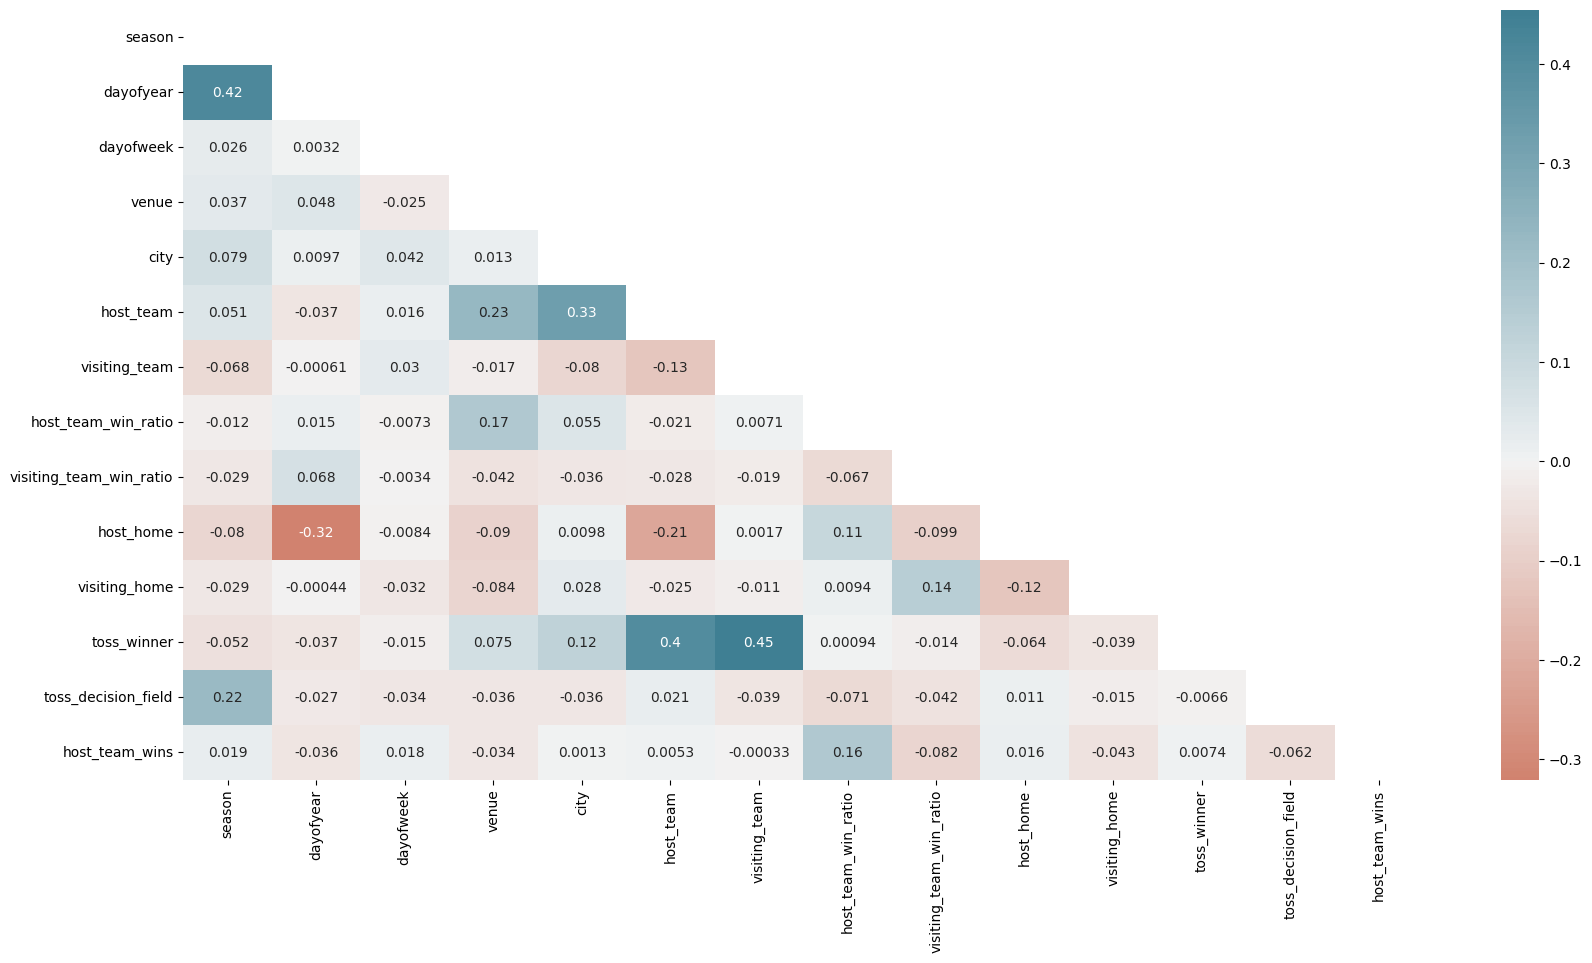

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
corr_matrix = mdf.corr()
mask = np.zeros_like(corr_matrix, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_matrix, cmap=sns.diverging_palette(20, 220, n=200), annot=True, mask=mask, center = 0)
plt.show()

# Splitting the dataset

In [ ]:
X = mdf.drop(columns=['host_team_wins'])
y = mdf['host_team_wins']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Cross-Validation on different models

### ExtraTreesClassifier
Finding the best parameters for ExtraTreesClassifier using RandomizedSearchCV

In [ ]:
et = ExtraTreesClassifier()

param_dist = {
    'n_estimators': [100, 250, 500, 1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 5, 6, 7, 8],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [2, 3, 4],
    'bootstrap': [False, True]
}

random_search = RandomizedSearchCV(estimator=et, param_distributions=param_dist, n_iter=100, cv=5, random_state=42, n_jobs=-1, verbose=3)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=ExtraTreesClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [False, True],
                                        'max_depth': [None, 5, 6, 7, 8],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [2, 3, 4],
                                        'min_samples_split': [2, 3, 4],
                                        'n_estimators': [100, 250, 500, 1000]},
                   random_state=42, verbose=3)

In [ ]:
print(f"Best parameters: {random_search.best_params_}")
print(f"Best cross-validation score: {random_search.best_score_}")

best_model = random_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print(f"Test set score: {test_score}")


Best parameters: {'n_estimators': 1000, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 5, 'bootstrap': True}
Best cross-validation score: 0.5670244484197973
Test set score: 0.5337423312883436


In [ ]:
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

In [ ]:
print('ATrS:', best_model.score(X_train, y_train))
print('ATeS:', best_model.score(X_test, y_test))
print(classification_report(y_test, y_pred))

# ATrS: 0.6902927580893683
# ATeS: 0.5337423312883436

ATrS: 0.6902927580893683
ATeS: 0.5337423312883436
              precision    recall  f1-score   support

           0       0.50      0.24      0.32        76
           1       0.54      0.79      0.64        87

    accuracy                           0.53       163
   macro avg       0.52      0.51      0.48       163
weighted avg       0.52      0.53      0.49       163



### XGBClassifier
Finding the best parameters for XGBClassifier using RandomizedSearchCV

In [ ]:
param_dist_xgb = {
    'n_estimators': [100, 250, 500, 1000],
    'max_depth': [None, 3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 2, 3, 4, 5]
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
random_search_xgb = RandomizedSearchCV(estimator=xgb, param_distributions=param_dist_xgb, n_iter=100, cv=5, random_state=42, n_jobs=-1, verbose=3)

# Fit the random search model for XGBClassifier
random_search_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='mlogloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learnin...
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8, 0.9,
                                                             1.0],
                                        'gamma': [0, 0.1, 0.2, 0.3],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [None, 3, 4, 5, 6, 7, 8, 9,
                                                      10],
                                        'min_child_weight': [1, 2, 3, 4, 5],
                                        'n_estimators': [100, 250, 500, 1000],
                                        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]},
                   random_state=42, verbose=3)

In [ ]:
print(f"Best parameters: {random_search_xgb.best_params_}")
print(f"Best cross-validation score: {random_search_xgb.best_score_}")

best_model_xgb = random_search_xgb.best_estimator_
test_score = best_model_xgb.score(X_test, y_test)
print(f"Test set score: {test_score}")
# Best parameters: {'subsample': 1.0, 'n_estimators': 500, 'min_child_weight': 4, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 0.8}

Best parameters: {'subsample': 1.0, 'n_estimators': 500, 'min_child_weight': 4, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 0.8}
Best cross-validation score: 0.5670244484197973
Test set score: 0.5460122699386503


In [ ]:
y_pred = best_model_xgb.predict(X_test)
y_pred_proba = best_model_xgb.predict_proba(X_test)

In [ ]:
print('ATrS:', best_model_xgb.score(X_train, y_train))
print('ATeS:', best_model_xgb.score(X_test, y_test))
print(classification_report(y_test, y_pred))

# ATrS: 0.8120184899845917
# ATeS: 0.5460122699386503

ATrS: 0.8120184899845917
ATeS: 0.5460122699386503
              precision    recall  f1-score   support

           0       0.52      0.41      0.46        76
           1       0.56      0.67      0.61        87

    accuracy                           0.55       163
   macro avg       0.54      0.54      0.53       163
weighted avg       0.54      0.55      0.54       163



### LGBMClassifier
Finding the best parameters for LGBMClassifier using RandomizedSearchCV

In [ ]:
# TODO: Do it starting here.
param_dist_lgbm = {
    'n_estimators': [100, 250, 500, 1000],
    'max_depth': [-1, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'num_leaves': [35, 45, 55],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'min_child_samples': [5, 10, 15, 20]
}

lgbm = LGBMClassifier()
random_search_lgbm = RandomizedSearchCV(estimator=lgbm, param_distributions=param_dist_lgbm, n_iter=100, cv=5, random_state=42, n_jobs=-1, verbose=3)

# Fit the random search model for LGBMClassifier
random_search_lgbm.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 358, number of negative: 291
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 229
[LightGBM] [Info] Number of data points in the train set: 649, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.551618 -> initscore=0.207210
[LightGBM] [Info] Start training from score 0.207210
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

RandomizedSearchCV(cv=5, estimator=LGBMClassifier(), n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8, 0.9,
                                                             1.0],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [-1, 5, 6, 7, 8],
                                        'min_child_samples': [5, 10, 15, 20],
                                        'n_estimators': [100, 250, 500, 1000],
                                        'num_leaves': [20, 31, 40, 50],
                                        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]},
                   random_state=42, verbose=3)

In [ ]:
print(f"Best parameters: {random_search_lgbm.best_params_}")
print(f"Best cross-validation score: {random_search_lgbm.best_score_}")

best_model_lgbm = random_search_lgbm.best_estimator_
test_score = best_model_lgbm.score(X_test, y_test)
print(f"Test set score: {test_score}")

# Best parameters: {'subsample': 1.0, 'num_leaves': 31, 'n_estimators': 100, 'min_child_samples': 20, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.9}

Best parameters: {'subsample': 1.0, 'num_leaves': 31, 'n_estimators': 100, 'min_child_samples': 20, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.9}
Best cross-validation score: 0.5639833035181873
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Test set score: 0.5214723926380368


In [ ]:
y_pred = best_model_lgbm.predict(X_test)
y_pred_proba = best_model_lgbm.predict_proba(X_test)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [ ]:
print('ATrS:', best_model_lgbm.score(X_train, y_train))
print('ATeS:', best_model_lgbm.score(X_test, y_test))
print(classification_report(y_test, y_pred))

# ATrS: 0.7010785824345146
# ATeS: 0.5214723926380368

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
ATrS: 0.7010785824345146
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
ATeS: 0.5214723926380368
              precision    recall  f1-score   support

           0       0.48      0.28      0.35        76
           1       0.54      0.74      0.62        87

    accuracy                           0.52       163
   macro avg       0.51      0.51      0.49       163
weighted avg       0.51      0.52      0.49       163



In [ ]:
model = best_model_xgb # Change to whichever model gives best accuracy from the above three models.

# Testing the model on user input

In [ ]:
def process_test_data(df):
    df = df.copy()

    df['season'] = pd.to_datetime(df['date'], format='%Y-%m-%d').dt.year
    df['dayofyear'] = pd.to_datetime(df['date'], format='%Y-%m-%d').dt.dayofyear
    df['dayofweek'] = pd.to_datetime(df['date'], format='%Y-%m-%d').dt.dayofweek
    df = df.drop(columns=['date'])

    df['host_team_home'] = False
    df['visiting_team_home'] = False

    df.loc[df['city'] == df['host_team'], 'host_team_home'] = True
    df.loc[df['city'] == df['visiting_team'], 'visiting_team_home'] = True

    df['host_team_win_ratio'] = df['host_team'].map(win_ratio)
    df['visiting_team_win_ratio'] = df['visiting_team'].map(win_ratio)

    df['host_team'] = team_le.transform(df['host_team'])
    df['visiting_team'] = team_le.transform(df['visiting_team'])
    df['city'] = team_le.transform(df['city'])
    df['toss_winner'] = team_le.transform(df['toss_winner'])

    df['venue'] = venue_le.transform(df['venue'])
    df['toss_decision_field'] = True

    df = df.reindex(columns=['season', 'dayofyear', 'dayofweek', 'venue', 'city',
                           'host_team', 'visiting_team', 'host_team_win_ratio', 'visiting_team_win_ratio', 'host_team_home', 'visiting_team_home',
                           'toss_winner',  'toss_decision_field'])

    return df

In [ ]:
from IPython.display import display
import ipywidgets as widgets
import pandas as pd
from datetime import datetime

teams = win_ratio.keys()
venues = mdf_clone['venue'].unique()

stadium_city_map = {
        'M Chinnaswamy Stadium': 'Bangalore',
        'M Chinnaswamy Stadium, Bengaluru': 'Bangalore',
        'Punjab Cricket Association Stadium, Mohali': 'Mohali',
        'Punjab Cricket Association IS Bindra Stadium, Mohali': 'Mohali',
        'Feroz Shah Kotla': 'Delhi',
        'Arun Jaitley Stadium': 'Delhi',
        'Arun Jaitley Stadium, Delhi': 'Delhi',
        'Wankhede Stadium': 'Mumbai',
        'Wankhede Stadium, Mumbai': 'Mumbai',
        'Eden Gardens': 'Kolkata',
        'Eden Gardens, Kolkata': 'Kolkata',
        'Sawai Mansingh Stadium': 'Jaipur',
        'Sawai Mansingh Stadium, Jaipur': 'Jaipur',
        'Rajiv Gandhi International Stadium, Uppal': 'Hyderabad',
        'Rajiv Gandhi International Stadium': 'Hyderabad',
        'Rajiv Gandhi International Stadium, Uppal, Hyderabad': 'Hyderabad',
        'MA Chidambaram Stadium, Chepauk': 'Chennai',
        'MA Chidambaram Stadium': 'Chennai',
        'MA Chidambaram Stadium, Chepauk, Chennai': 'Chennai',
        'Dr DY Patil Sports Academy': 'Mumbai',
        'Dr DY Patil Sports Academy, Mumbai': 'Mumbai',
        'Newlands': 'Cape Town',
        "St George's Park": 'Port Elizabeth',
        'Kingsmead': 'Durban',
        'SuperSport Park': 'Centurion',
        'Buffalo Park': 'East London',
        'New Wanderers Stadium': 'Johannesburg',
        'De Beers Diamond Oval': 'Kimberley',
        'OUTsurance Oval': 'Bloemfontein',
        'Brabourne Stadium': 'Mumbai',
        'Brabourne Stadium, Mumbai': 'Mumbai',
        'Sardar Patel Stadium, Motera': 'Ahmedabad',
        'Barabati Stadium': 'Cuttack',
        'Vidarbha Cricket Association Stadium, Jamtha': 'Nagpur',
        'Himachal Pradesh Cricket Association Stadium': 'Dharamsala',
        'Himachal Pradesh Cricket Association Stadium, Dharamsala': 'Dharamsala',
        'Nehru Stadium': 'Kochi',
        'Holkar Cricket Stadium': 'Indore',
        'Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium': 'Visakhapatnam',
        'Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium, Visakhapatnam': 'Visakhapatnam',
        'Subrata Roy Sahara Stadium': 'Pune',
        'Maharashtra Cricket Association Stadium': 'Pune',
        'Maharashtra Cricket Association Stadium, Pune': 'Pune',
        'Shaheed Veer Narayan Singh International Stadium': 'Raipur',
        'JSCA International Stadium Complex': 'Ranchi',
        'Sheikh Zayed Stadium': 'Abu Dhabi',
        'Sharjah Cricket Stadium': 'Sharjah',
        'Dubai International Cricket Stadium': 'Dubai',
        'Saurashtra Cricket Association Stadium': 'Rajkot',
        'Green Park': 'Kanpur',
        'Narendra Modi Stadium, Ahmedabad': 'Ahmedabad',
        'Zayed Cricket Stadium, Abu Dhabi': 'Abu Dhabi',
        'Eden Gardens, Kolkata': 'Kolkata',
        'Punjab Cricket Association IS Bindra Stadium': 'Mohali',
        'Punjab Cricket Association IS Bindra Stadium, Mohali, Chandigarh': 'Mohali',
        'Bharat Ratna Shri Atal Bihari Vajpayee Ekana Cricket Stadium, Lucknow': 'Lucknow',
        'Barsapara Cricket Stadium, Guwahati': 'Guwahati',
        'Maharaja Yadavindra Singh International Cricket Stadium, Mullanpur': 'Mullanpur'
}

date = widgets.DatePicker(description='Select a date', disabled=False)
venue = widgets.Dropdown(options=venues, description='Venue:')
host_team = widgets.Dropdown(options=teams, description='Host Team :')
visiting_team = widgets.Dropdown(options=teams, description='Visiting Team :')
toss_winner = widgets.Dropdown(options=teams, description='Toss Winner:')
toss_decision_field = widgets.Checkbox(value=False, description='Toss winner chose fielding?')

prediction_result = widgets.Output()

def handle_prediction(btn):
    with prediction_result:
        prediction_result.clear_output()
        if host_team.value == visiting_team.value:
            print("Team1 and team2 cannot be the same!")
            return

        test_data = {
            'date': date.value,
            'venue': venue.value,
            'city': stadium_city_map[venue.value],
            'host_team': host_team.value,
            'visiting_team': visiting_team.value,
            'toss_winner': toss_winner.value,
            'toss_decision_field': True
        }

        if None in test_data.values():
            print("Please fill all fields.")
            return

        test_data_df = pd.Series(test_data).to_frame().T
        test_data_df = process_test_data(test_data_df)
        print(f"Processed Test Data:\n{test_data_df}")
        print(f"Toss decision: {test_data_df.toss_decision_field}")
        prediction = model.predict_proba(test_data_df)[0]
        print(f"Prediction: \n{host_team.value} - {prediction[1]} \n{visiting_team.value} - {prediction[0]}")

predict_button = widgets.Button(description='Predict')
predict_button.on_click(handle_prediction)

input_form = widgets.VBox([
    date, venue, host_team, visiting_team, toss_winner, toss_decision_field,
    predict_button, prediction_result
])

display(input_form)